In [33]:
import requests, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from nnSampleVerification import plotter, signedDistanceFunction, verify

In [ ]:
betaDKW = 0.001
epsilonDKW = 0.1
Delta = 1-0.9
verifDKW = verify.usingDKW(betaDKW,epsilonDKW,Delta)
betaScenario = 0.001
verifScenario = verify.usingScenario(betaScenario,Delta)

# Import TaxiRun h5 using the following link: 
url = 'https://www.dropbox.com/scl/fi/f6m4ejxp20n3iifscmodq/TaxiRunFixed.h5?rlkey=di2d5ys9x6vprt5ws6pmo4xd6&st=roxxmgkg&dl=1'



def download_file(url, filename):
    if not os.path.exists(filename):
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            print(f'Downloading {filename} ({total_size // 1024} KB):', end='')
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        done = int(50 * f.tell() / total_size)
                        print(f'\r[{"=" * done}{" " * (50-done)}]', end='')
    else:
        print(f'{filename} already exists. Skipping download.')

download_file(url, 'TaxiRunFixed.h5')
f = h5py.File('./TaxiRunFixed.h5', 'r')
tot_full_runs = 408
y_pos = np.zeros((tot_full_runs,1))

for i in np.arange(0,tot_full_runs):

    run_num = 'run_' + str(i+1)
    group = f.get(run_num)
    y_pos[i] = group.get('cte')[-1]

-----------------------------------------------------------------
Error between true and empirical CDF (i.e. \sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon): epsilon = 0.1
Confidence level (i.e. P(\sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon) >= 1-\beta): 1-beta = 0.999
Number of samples needed from simulator/sampler: 381
Please add the specification by calling "usingDKW.addSpecification()" function.
Then, add samples by calling "usingDKW.addSamples()" function.
-----------------------------------------------------------------
-----------------------------------------------------------------
Confidence level (i.e. P(P(g_C(f(x)) <= 0) >= 1-\Delta) >= 1-\beta): 1-beta = 0.999, 1-Delta = 0.9
Number of samples needed from simulator/sampler: 126
Please add the specification by calling "usingScenario.addSpecification()" function.
Then, add samples by calling "usingScenario.addSamples()" function.
-----------------------------------------------------------------
[=====================

In [ ]:
# Center of the norm-ball
center = np.array(0.0)
zero_radius_fixed = np.array(1.0)
normSDF = signedDistanceFunction.norm(center,zero_radius_fixed,norm=1)

# Add SDF: 
verifDKW.specification(normSDF)
verifScenario.specification(normSDF)

-----------------------------------------------------------------
Specification updated. Please add samples by calling 'usingDKW.addSamples()' function.
----------------------------------------------------------------
-----------------------------------------------------------------
Specification updated. Please add samples by calling 'usingScenario.addSamples()' function.
----------------------------------------------------------------


In [ ]:
# Generate samples
samples = y_pos
# Add samples to the verifier
verifDKW.samples(samples[0:verifDKW.samplesRequired()])    
verifScenario.samples(samples[0:verifScenario.samplesRequired()])

Number of samples needed from simulator/sampler: 381
Number of samples needed from simulator/sampler: 126


In [ ]:
# Check if the samples satisfy the specification: 
verifDKW.SpecificationSatisfied()
verifScenario.SpecificationSatisfied()

-----------------------------------------------------------------
Specification NOT satisfied as probability is 15.485564304461944% +/- 10.0% which is less than 0.9
Run "usingDKW.modifySetScaling()" to find the scaling factor that satisfies the specification at satisfaction probability.
-----------------------------------------------------------------
-----------------------------------------------------------------
Specification NOT satisfied as scaling is 1.2520071507626938 which is greater than 0
Run "usingScenario.modifySetScaling()" to find the scaling factor that satisfies the specification at satisfaction probability.
-----------------------------------------------------------------


In [ ]:
# Modify the zero level set:
setEnlargementDKW = verifDKW.modifySetScaling()
setEnlargementScenario = verifScenario.modifySetScaling()

-----------------------------------------------------------------
DKW-based scaling factor is modified to 0.632120601120107 from the previous value: 0.0
Please rerun "usingDKW.SpecificationSatisfied()" to check if the specification is satisfied.
-----------------------------------------------------------------
-----------------------------------------------------------------
Scenario-based scaling factor is modified to 1.2520071507626938 from the previous value: 0.0
Please rerun "usingScenario.SpecificationSatisfied()" to check if the specification is satisfied.
-----------------------------------------------------------------


In [ ]:
# Check if the samples satisfy the specification: 
verifDKW.SpecificationSatisfied()
verifScenario.SpecificationSatisfied()

-----------------------------------------------------------------
Specification satisfied with probability: 90.02624671916011% +/- 10.0% which is greater than 0.9
-----------------------------------------------------------------
-----------------------------------------------------------------
Specification satisfied as scaling is 0.0 which is equal to 0
-----------------------------------------------------------------


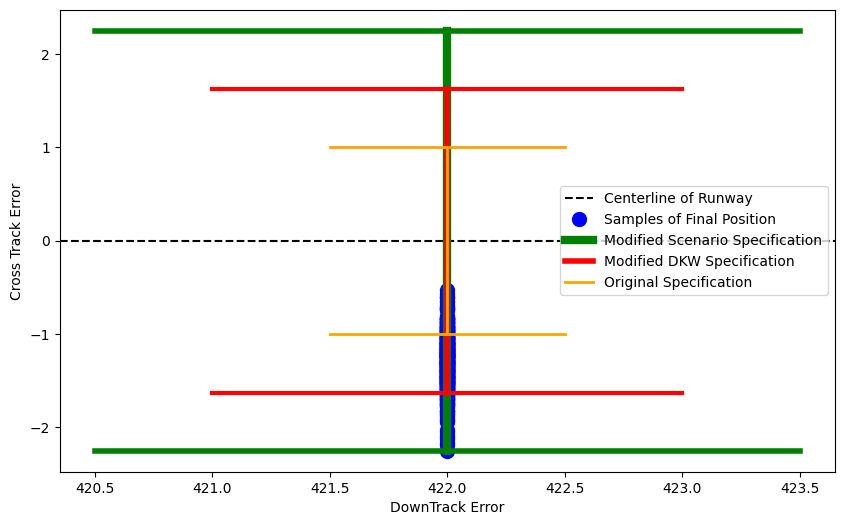

In [ ]:


# Create a plot
plt.figure(figsize=(10, 6))

# Add horizontal lines at 10 and -10
plt.axhline(y=0, color='k', linestyle='--', label='Centerline of Runway')

# Plot the samples
plt.plot(422*np.ones(samples.shape[0]),samples, 'o', label='Samples of Final Position', markersize=10, color='blue')

plt.plot([422, 422], [-1-setEnlargementScenario, 1+setEnlargementScenario], '-', color='green', linewidth=6, label='Modified Scenario Specification')
plt.plot([420.5, 423.5], [1+setEnlargementScenario, 1+setEnlargementScenario], '-', color='green', linewidth=4)
plt.plot([420.5, 423.5], [-1-setEnlargementScenario, -1-setEnlargementScenario], '-', color='green',linewidth=4)
plt.plot([422, 422], [-1-setEnlargementDKW, 1+setEnlargementDKW], '-', color='red', linewidth=4, label='Modified DKW Specification')
plt.plot([421, 423], [1+setEnlargementDKW, 1+setEnlargementDKW], '-', color='red', linewidth=3)
plt.plot([421, 423], [-1-setEnlargementDKW, -1-setEnlargementDKW], '-', color='red',linewidth=3)
# Add box and whisker like lines at y = ±1.5 and x = 422
plt.plot([422, 422], [-1, 1], '-', color='orange', linewidth=2)
plt.plot([421.5, 422.5], [1, 1], '-', color='orange', linewidth=2)
plt.plot([421.5, 422.5], [-1, -1], '-', color='orange',linewidth=2, label='Original Specification')




# Add labels and title
plt.xlabel('DownTrack Error')
plt.ylabel('Cross Track Error')

plt.legend(loc='best')

# Show the plot
plt.show()